In [1]:
# Monkey V1/V4 LFP Analysis — Using stochastic_dynamics Package
# ==============================================================
# This notebook reproduces the MonkeyData.ipynb analysis using our clean package API.

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from pathlib import Path

# Our package imports
import sys
sys.path.insert(0, '..')
from stochastic_dynamics.models import ARModel
from stochastic_dynamics.tools import (
    PSDTool, ACFTool, BandpassTool, NotchTool,
    HilbertTool, EnvelopeTool, EnvelopeNormalizeTool
)

# Plotting style
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

COLOR_MAIN = "black"
COLOR_ALT = "darkred"

print("Imports complete.")

Imports complete.


In [2]:
# =============================================================================
# 1. Load LFP Data
# =============================================================================

data_dir = Path('./data')
file_names = ['NSP1_array1_LFP.mat', 'NSP1_array2_LFP.mat', 'NSP2_array3_LFP.mat']

data = []
for fname in file_names:
    full_path = data_dir / fname
    if full_path.exists():
        data.append(sio.loadmat(str(full_path)))
        print(f"Loaded: {fname}")
    else:
        print(f"Missing: {fname}")

# Concatenate arrays
LFP_list, Array_ID_list = [], []
for d in data:
    LFP_list.append(d['lfp'])
    Array_ID_list.append(d['Array_ID'])

LFP = np.concatenate(LFP_list, axis=1)
Array_ID = np.concatenate(Array_ID_list)

Fs = 500  # Sampling frequency (Hz)
Time = np.arange(LFP.shape[0]) / Fs

print(f"\nLFP shape: {LFP.shape} (samples × channels)")
print(f"Duration: {LFP.shape[0] / Fs:.1f} seconds")
print(f"Arrays loaded: {np.unique(Array_ID)}")

Loaded: NSP1_array1_LFP.mat
Loaded: NSP1_array2_LFP.mat
Loaded: NSP2_array3_LFP.mat

LFP shape: (1011623, 192) (samples × channels)
Duration: 2023.2 seconds
Arrays loaded: [1 2 3]


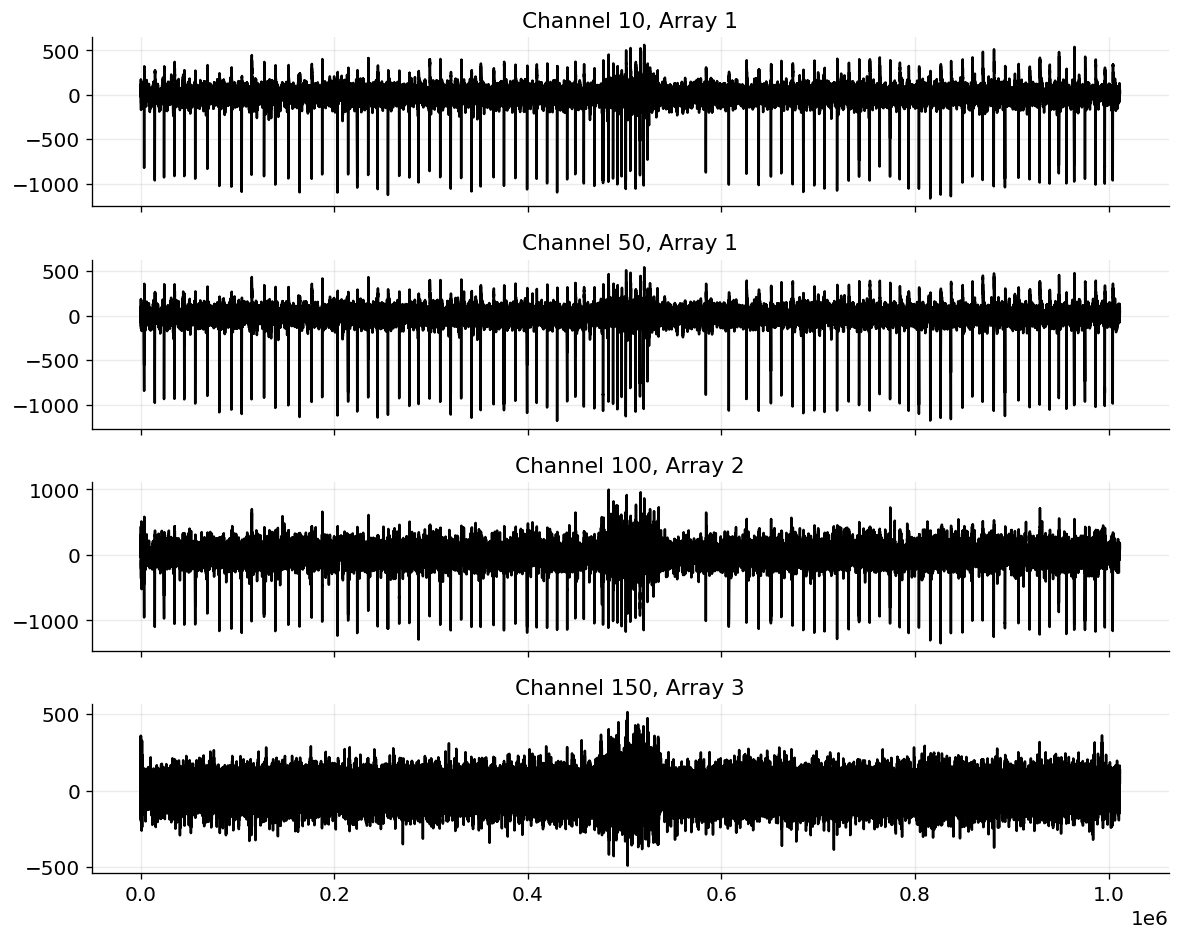

In [3]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
for i, ch in enumerate([10, 50, 100, 150]):
    if ch < LFP.shape[1]:
        axes[i].plot(LFP[:, ch], "k")
        array_idx = ch // 64  # which array (0, 1, or 2)
        axes[i].set_title(f"Channel {ch}, Array {Array_ID[array_idx, 0]}")
plt.tight_layout()
plt.show()

In [4]:
# =============================================================================
# 2. Preprocessing: Select Channel, Notch Filter, Envelope Normalization
# =============================================================================

# Select a single channel for analysis
CHANNEL = 150  # Pick any channel
x_raw = LFP[:, CHANNEL].astype(float)

# Apply notch filter first (remove line noise)
notch = NotchTool(freqs=(60.0, 120.0), Q=30.0)
x_notch = notch(x_raw, fs=Fs)

# Apply envelope normalization (bandpass + Hilbert envelope + divide out)
# This flattens amplitude modulations while preserving phase structure
env_norm = EnvelopeNormalizeTool(fband=(1.0, 80.0), env_lp_hz=3.0, keep_scale=True)
xs, x_bp, envelope = env_norm(x_notch, fs=Fs)

print(f"Selected channel: {CHANNEL}")
print(f"Signal length: {len(xs)} samples ({len(xs)/Fs:.1f} s)")
print(f"Envelope normalization: fband=(1, 80) Hz, env_lp=3.0 Hz")

Selected channel: 150
Signal length: 1011623 samples (2023.2 s)
Envelope normalization: fband=(1, 80) Hz, env_lp=3.0 Hz


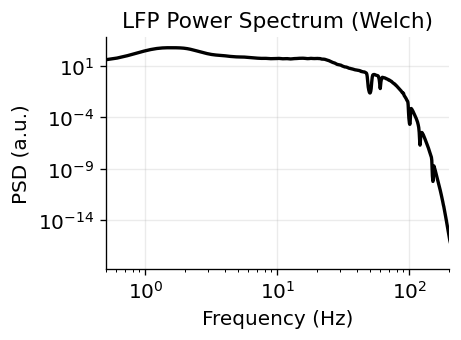

In [5]:
# =============================================================================
# 3. Plot: Power Spectral Density (Welch)
# =============================================================================

from scipy.ndimage import gaussian_filter1d

# Compute PSD using our package
psd_tool = PSDTool(nperseg=4096)
freqs, psd = psd_tool(xs, fs=Fs)

# Smooth for visualization
psd_smooth = gaussian_filter1d(psd, sigma=2)

fig, ax = plt.subplots(figsize=(4, 3))
ax.loglog(freqs, psd_smooth, color='k', lw=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (a.u.)")
ax.set_title("LFP Power Spectrum (Welch)")
ax.set_xlim(0.5, 200)
plt.tight_layout()
plt.show()

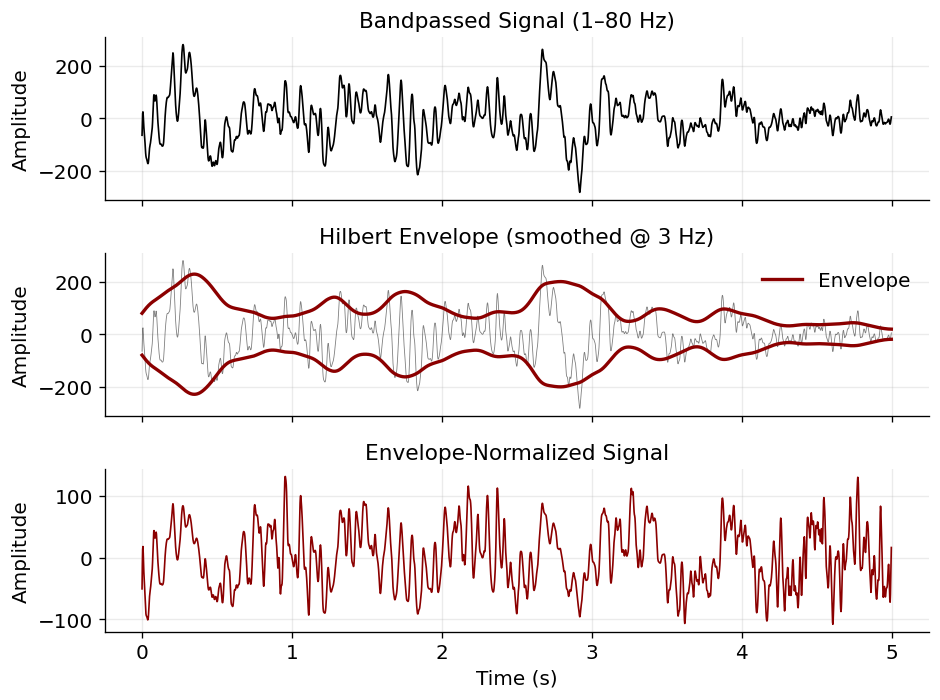

In [6]:
# =============================================================================
# 4. Plot: Envelope Normalization Effect (Time-Domain Comparison)
# =============================================================================

snippet_sec = 5
N_snippet = int(snippet_sec * Fs)
t_snip = Time[:N_snippet]

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Original bandpassed signal
axes[0].plot(t_snip, x_bp[:N_snippet], lw=1, color=COLOR_MAIN)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Bandpassed Signal (1–80 Hz)")

# Envelope
axes[1].plot(t_snip, x_bp[:N_snippet], lw=0.5, color=COLOR_MAIN, alpha=0.5)
axes[1].plot(t_snip, envelope[:N_snippet], lw=2, color=COLOR_ALT, label="Envelope")
axes[1].plot(t_snip, -envelope[:N_snippet], lw=2, color=COLOR_ALT)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Hilbert Envelope (smoothed @ 3 Hz)")
axes[1].legend(frameon=False)

# Envelope-normalized signal
axes[2].plot(t_snip, xs[:N_snippet], lw=1, color=COLOR_ALT)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Envelope-Normalized Signal")

plt.tight_layout()
plt.show()

Manual override: p = 6
Stable: False


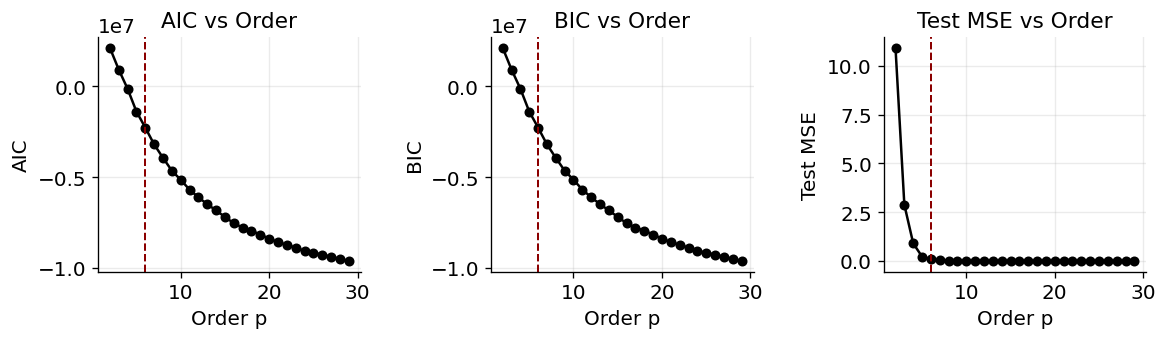

In [15]:
# =============================================================================
# 5. AR Model Selection: Sweep Orders, Compute AIC/BIC/MSE, Plot Elbow
# =============================================================================

# Train/test split
N = len(xs)
ntr = int(0.9 * N)
x_train = xs[:ntr]

# Sweep orders
p_list = list(range(2, 30))
models = {}
aic_list, bic_list, mse_list = [], [], []

for p in p_list:
    m = ARModel(p=p).fit(x_train)
    models[p] = m
    
    # Train predictions for AIC/BIC
    y_pred_tr = m.predict(x_train)
    y_true_tr = x_train[p:]
    
    aic_list.append(m.aic(y_true_tr, y_pred_tr))
    bic_list.append(m.bic(y_true_tr, y_pred_tr))
    
    # Test MSE
    y_pred_full = m.predict(xs)
    y_true_full = xs[p:]
    mse_te = np.mean((y_true_full[ntr-p:] - y_pred_full[ntr-p:])**2)
    mse_list.append(mse_te)

# =====================================================================
# Override: set OVERRIDE_P to a value, or None to use BIC-optimal
# =====================================================================
OVERRIDE_P = 6  # <-- Set to e.g. 10 to override, or None for BIC

if OVERRIDE_P is not None:
    best_p = OVERRIDE_P
    print(f"Manual override: p = {best_p}")
else:
    best_p = p_list[np.argmin(bic_list)]
    print(f"BIC-optimal: p = {best_p}")

model = models[best_p]
print(f"Stable: {model.is_stable()}")


# --- 1x3 Subplot: AIC, BIC, MSE ---
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, vals, label, color in zip(
    axes,
    [aic_list, bic_list, mse_list],
    ["AIC", "BIC", "Test MSE"],
    [COLOR_MAIN, COLOR_MAIN, COLOR_MAIN]
):
    ax.plot(p_list, vals, marker='o', color=color, lw=1.5, ms=5)
    ax.set_xlabel("Order p")
    ax.set_ylabel(label)
    ax.set_title(f"{label} vs Order")
    ax.axvline(best_p, linestyle='--', color=COLOR_ALT, linewidth=1.2)

plt.tight_layout()
plt.show()

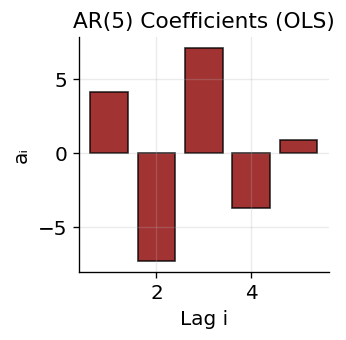

In [8]:
# =============================================================================
# 7. Plot: AR Coefficients (Bar Chart)
# =============================================================================

fig, ax = plt.subplots(figsize=(3, 3))
ax.bar(np.arange(1, model.p + 1), model.coeffs, color=COLOR_ALT, edgecolor=COLOR_MAIN, alpha=0.8)
ax.set_xlabel("Lag i")
ax.set_ylabel("aᵢ")
ax.set_title(f"AR({model.p}) Coefficients (OLS)")
plt.tight_layout()
plt.show()

In [9]:
# =============================================================================
# 8. Hybrid Prediction: Controllable k-step Rollout
# =============================================================================

# Configuration
REFRESH_EVERY = 10  # Refresh ground truth every 10 steps
p = model.p
ntr = int(0.9 * len(xs))
n_test = len(xs) - ntr - p
start_idx = ntr + p

# Use our package's hybrid_predict method
y_pred_hybrid = model.hybrid_predict(xs, start_idx=start_idx, n_steps=n_test, refresh_every=REFRESH_EVERY)
y_true_test = xs[start_idx : start_idx + n_test]

print(f"Test samples: {n_test}")
print(f"Refresh every: {REFRESH_EVERY} steps")

Test samples: 101158
Refresh every: 10 steps


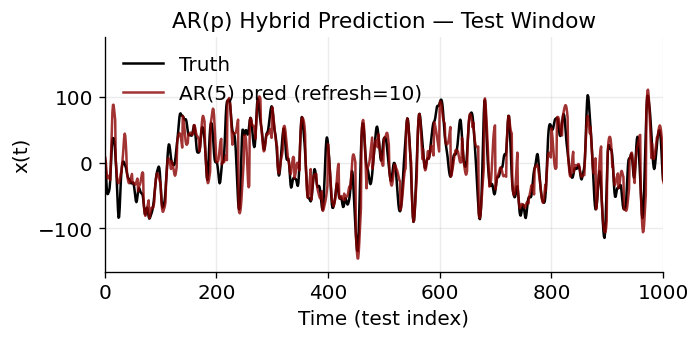

In [10]:
# =============================================================================
# 9. Plot: Prediction vs Ground Truth (Test Window)
# =============================================================================

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(y_true_test, color=COLOR_MAIN, lw=1.5, label="Truth")
ax.plot(y_pred_hybrid, color=COLOR_ALT, lw=1.5, alpha=0.8, label=f"AR({p}) pred (refresh={REFRESH_EVERY})")
ax.set_xlabel("Time (test index)")
ax.set_ylabel("x(t)")
ax.set_title("AR(p) Hybrid Prediction — Test Window")
ax.legend(frameon=False)
ax.set_xlim(0, 1000)
plt.tight_layout()
plt.show()

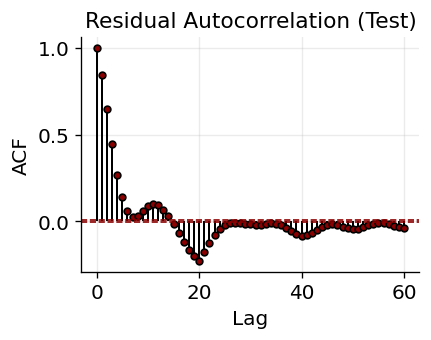

In [11]:
# =============================================================================
# 10. Plot: Residual Autocorrelation (ACF)
# =============================================================================

# Compute residual ACF using our package
acf_tool = ACFTool(max_lag=60)
residuals = y_true_test - y_pred_hybrid
lags, acf_vals = acf_tool(residuals, fs=Fs)
n_resid = len(residuals)
bound = 1.96 / np.sqrt(n_resid)

fig, ax = plt.subplots(figsize=(4, 3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
plt.setp(stemlines, color=COLOR_MAIN, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=4, markeredgecolor=COLOR_MAIN, markerfacecolor=COLOR_ALT)
ax.axhline(bound, linestyle='--', color=COLOR_ALT, linewidth=1)
ax.axhline(-bound, linestyle='--', color=COLOR_ALT, linewidth=1)
ax.set_xlabel("Lag")
ax.set_ylabel("ACF")
ax.set_title("Residual Autocorrelation (Test)")
plt.tight_layout()
plt.show()

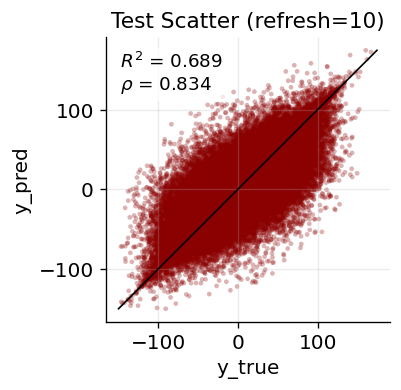

R² = 0.6888, Pearson ρ = 0.8337


In [12]:
# =============================================================================
# 11. Plot: y_pred vs y_true Scatter (with R² and ρ)
# =============================================================================

fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.scatter(y_true_test, y_pred_hybrid, c=COLOR_ALT, alpha=0.3, s=8, edgecolors="none")

# Identity line
vmin = min(y_true_test.min(), y_pred_hybrid.min())
vmax = max(y_true_test.max(), y_pred_hybrid.max())
ax.plot([vmin, vmax], [vmin, vmax], color=COLOR_MAIN, lw=1)

# Metrics
yt = y_true_test - y_true_test.mean()
yp = y_pred_hybrid - y_pred_hybrid.mean()
corr = np.dot(yt, yp) / np.sqrt(np.dot(yt, yt) * np.dot(yp, yp) + 1e-12)
ss_res = np.sum((y_true_test - y_pred_hybrid)**2)
ss_tot = np.sum((y_true_test - y_true_test.mean())**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)

ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("y_true")
ax.set_ylabel("y_pred")
ax.set_title(f"Test Scatter (refresh={REFRESH_EVERY})")
plt.tight_layout()
plt.show()

print(f"R² = {r2:.4f}, Pearson ρ = {corr:.4f}")

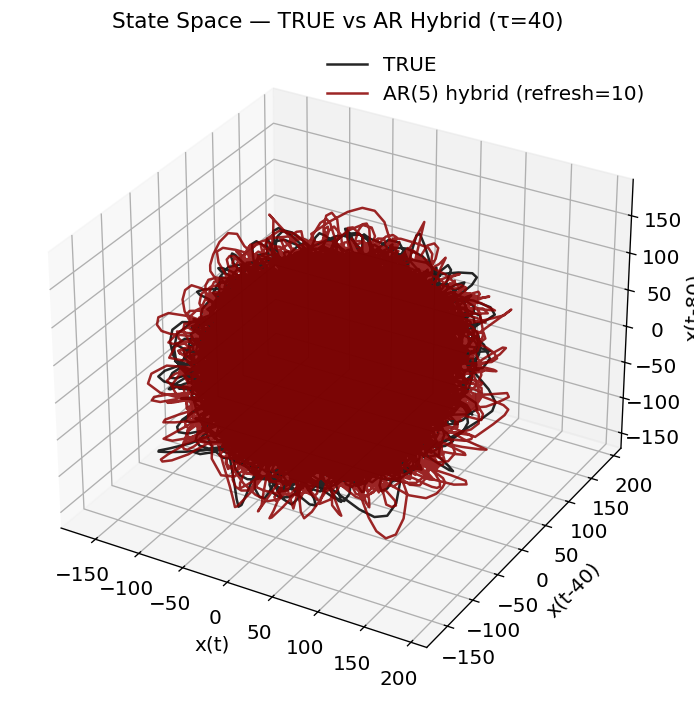

In [13]:
# =============================================================================
# 12. Plot: 3D State Space (Delay Embedding)
# =============================================================================

from stochastic_dynamics.embedders import DelayEmbedder

tau = 40  # Embedding delay

# Embed true test signal 
embedder = DelayEmbedder(m=3, tau=tau)
X3_true = embedder(y_true_test)

# Embed predictions (variance-matched for fair comparison)
y_pred_matched = y_pred_hybrid - y_pred_hybrid.mean()
y_pred_matched = y_pred_matched * (y_true_test.std() / (y_pred_matched.std() + 1e-12)) + y_true_test.mean()
X3_pred = embedder(y_pred_matched)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color=COLOR_MAIN, alpha=0.85, label="TRUE")
ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color=COLOR_ALT, alpha=0.85,
        label=f"AR({p}) hybrid (refresh={REFRESH_EVERY})")
ax.set_title(f"State Space — TRUE vs AR Hybrid (τ={tau})")
ax.set_xlabel("x(t)")
ax.set_ylabel(f"x(t-{tau})")
ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

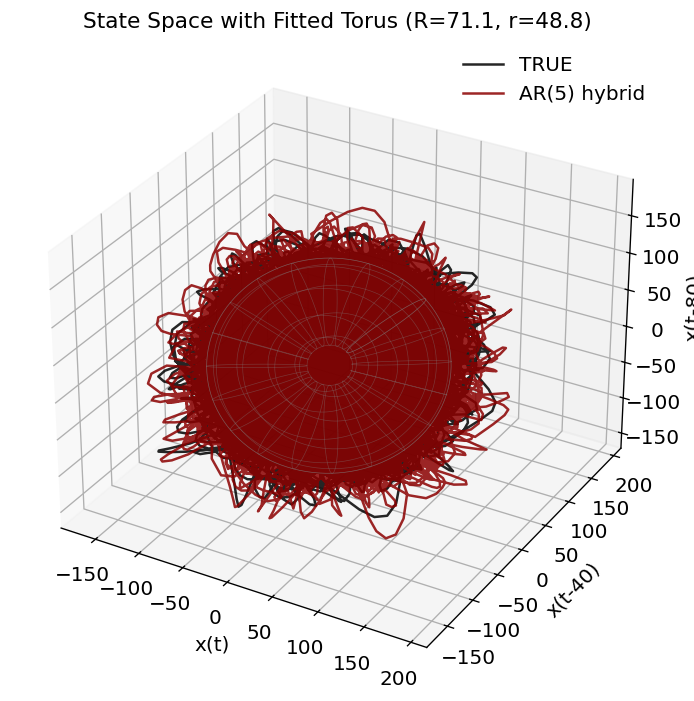

Fitted torus: R_major = 71.08, r_minor = 48.82


In [14]:
# =============================================================================
# 13. Torus Fitting (Optional: Manifold Analysis)
# =============================================================================

def fit_torus(points):
    """
    Fit a torus to 3D point cloud using PCA + Kasa circle fit.
    Returns: center C, rotation R, major radius Rmaj, minor radius rmin.
    """
    P = np.asarray(points)
    C0 = P.mean(axis=0)
    Pc = P - C0
    
    # PCA: symmetry axis = smallest variance
    cov = Pc.T @ Pc / len(Pc)
    evals, evecs = np.linalg.eigh(cov)
    ez = evecs[:, np.argmin(evals)]
    ex = evecs[:, np.argmax(evals)]
    ex -= ex.dot(ez) * ez
    ex /= np.linalg.norm(ex)
    ey = np.cross(ez, ex)
    R = np.stack([ex, ey, ez], axis=1)
    Pp = (R.T @ Pc.T).T
    
    x, y, z = Pp[:, 0], Pp[:, 1], Pp[:, 2]
    
    # Kasa circle fit in x'y'
    A = np.column_stack([2*x, 2*y, np.ones_like(x)])
    b = x**2 + y**2
    cx, cy, c = np.linalg.lstsq(A, b, rcond=None)[0]
    Rmaj = np.sqrt(max(c + cx**2 + cy**2, 0.0))
    
    # Tube radius from residuals
    rho_c = np.sqrt((x - cx)**2 + (y - cy)**2)
    rmin = np.sqrt(np.mean((rho_c - Rmaj)**2 + z**2))
    
    C = C0 + R @ np.array([cx, cy, 0.0])
    return C, R, float(Rmaj), float(rmin)

def torus_mesh(C, R, Rmaj, rmin, nu=120, nv=60):
    """Generate torus wireframe mesh."""
    u = np.linspace(0, 2*np.pi, nu)
    v = np.linspace(0, 2*np.pi, nv)
    U, V = np.meshgrid(u, v, indexing='ij')
    xp = (Rmaj + rmin*np.cos(V)) * np.cos(U)
    yp = (Rmaj + rmin*np.cos(V)) * np.sin(U)
    zp = rmin*np.sin(V)
    Pw = (R @ np.stack([xp, yp, zp], axis=0).reshape(3, -1)).T + C
    return Pw[:, 0].reshape(nu, nv), Pw[:, 1].reshape(nu, nv), Pw[:, 2].reshape(nu, nv)

# Fit torus to true trajectory
C, Rmat, Rmaj, rmin = fit_torus(X3_true)
Xt, Yt, Zt = torus_mesh(C, Rmat, Rmaj, rmin)

# Plot with torus wireframe
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color=COLOR_MAIN, alpha=0.85, label="TRUE")
ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color=COLOR_ALT, alpha=0.85,
        label=f"AR({p}) hybrid")
ax.plot_wireframe(Xt, Yt, Zt, rstride=6, cstride=6, color='gray', linewidth=0.4, alpha=0.4)
ax.set_title(f"State Space with Fitted Torus (R={Rmaj:.1f}, r={rmin:.1f})")
ax.set_xlabel("x(t)")
ax.set_ylabel(f"x(t-{tau})")
ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"Fitted torus: R_major = {Rmaj:.2f}, r_minor = {rmin:.2f}")